<a href="https://colab.research.google.com/github/ropero99/TAM_2025_S2/blob/main/25_Parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Librerías y parámetros globales Configuración

In [1]:
# Bloque 0: librerías y parámetros globales
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# parámetros reproducibilidad / visualización
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Función que calcula la varianza del ruido a partir del SNR en dB

In [2]:
# Bloque 1: función que calcula la varianza del ruido a partir del SNR en dB
def var_snr(signal, snr_db):
    """
    signal: array de la señal limpia
    snr_db: SNR en decibelios
    retorna: varianza (sigma^2) del ruido que da ese SNR
    """
    P_signal = np.mean(signal**2)                  # estimador de potencia de la señal (media de x^2)
    snr_linear = 10 ** (snr_db / 10.0)             # SNR en escala lineal
    var_noise = P_signal / snr_linear              # varianza del ruido

    return var_noise

    # Se eleva la señal al cuadrado → para calcular la potencia promedio.
    #Se pasa de dB a lineal → porque las fórmulas de potencia usan la escala lineal.
    #Propósito → poder generar ruido con la potencia exacta que logre el SNR deseado.

### Generar la señal sinc (limpia) y añadir ruido

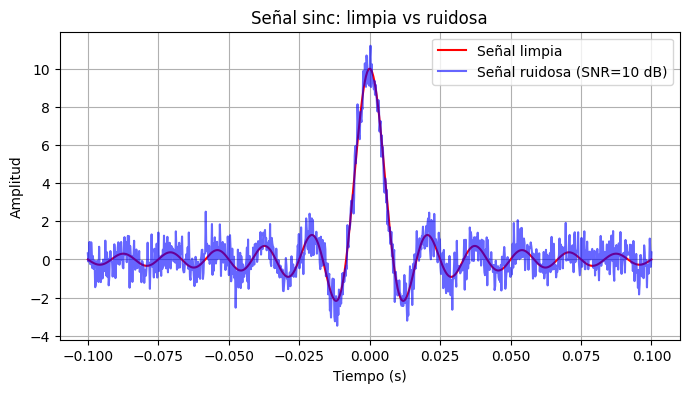

In [3]:
# Bloque 2: generar sinc (señal limpia) y añadir ruido
A = 10                                                                          # amplitud
Fo = 60                                                                         # frecuencia (Hz) usada en el ejemplo
n_samples = 1000
t = np.linspace(-0.1, 0.1, n_samples)                                           # tiempo
t_sinc = t.copy()
t_sinc[t_sinc == 0] = 1e-12                                                     # evitar división por cero

# Señal sinc limpia
signal_clean = A * np.sin(2 * np.pi * Fo * t_sinc) / (2 * np.pi * Fo * t_sinc)  ###________###

# Elegir SNR y generar ruido
snr_db = 10                                                                     # puedes probar 0, 5, 10, 20, 30
var_noise = var_snr(signal_clean, snr_db)                                       # llamado a la funcion var_snr()
noise = np.sqrt(var_noise) * np.random.randn(n_samples)
signal_noisy = signal_clean + noise

# Visualización rápida
plt.figure(figsize=(8,4))
plt.plot(t, signal_clean, 'r-', label='Señal limpia')
plt.plot(t, signal_noisy, 'b-', alpha=0.6, label=f'Señal ruidosa (SNR={snr_db} dB)')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal sinc: limpia vs ruidosa')
plt.grid(True)
plt.show()


### Preparar datos (X, y, y_clean) y dividir en train/test

In [4]:
# Bloque 3: preparar datos para modelado y dividir en train/test
X = t.reshape(-1, 1)          # característica (tiempo)
y = signal_noisy              # objetivo con ruido
y_clean = signal_clean        # referencia "ground truth"

# división 70% entrenamiento / 30% prueba
X_train, X_test, y_train, y_test, y_clean_train, y_clean_test = train_test_split(
    X, y, y_clean, test_size=0.3, random_state=RANDOM_STATE, shuffle=True
)

print("Shapes: X_train", X_train.shape, "X_test", X_test.shape)


Shapes: X_train (700, 1) X_test (300, 1)


### Función que entrena un modelo polinomial de grado Q y devuelve errores

In [5]:
# Bloque 4: función que entrena Ridge sobre features polinomiales y retorna errores
def fit_poly_ridge_and_eval(X_train, y_train, X_test, y_test, X_all, y_clean_train, y_clean_test, degree, alpha=1e-10):
    """
    degree: orden del polinomio
    alpha: regularización Ridge (lambda)
    retorna: diccionario con predicciones y MSE (vs noisy y vs clean)
    """
    # crear diseño polinomial
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    Phi_train = poly.fit_transform(X_train)
    Phi_test  = poly.transform(X_test)
    Phi_all = poly.transform(X_all)

    # entrenar Ridge
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    model.fit(Phi_train, y_train)

    # predicciones
    pred_train = model.predict(Phi_train)
    pred_test  = model.predict(Phi_test)
    pred_all   = model.predict(Phi_all)

    # errores MSE
    mse_train = mean_squared_error(y_train, pred_train)            # vs noisy (train)
    mse_test  = mean_squared_error(y_test, pred_test)              # vs noisy (test)
    mse_true_train = mean_squared_error(y_clean_train, pred_train) # vs clean (train)
    mse_true_test  = mean_squared_error(y_clean_test, pred_test)   # vs clean (test)

    return {
        'model': model,
        'poly': poly,
        'pred_all': pred_all,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mse_true_train': mse_true_train,
        'mse_true_test': mse_true_test
    }


### Bucle que evalúa muchos órdenes y selecciona el mejor

In [6]:
# Bloque 5: evaluar varios órdenes y guardar resultados
max_order = 300   # cuidado: órdenes altos pueden ser numéricamente inestables
alphaR = 1e-100   # regularización (prueba varios valores)
results = []

best = {'order': None, 'mse_true_test': np.inf, 'model': None, 'poly': None}

for Q in range(1, max_order + 1):
    res = fit_poly_ridge_and_eval(
        X_train, y_train, X_test, y_test, X, y_clean_train, y_clean_test,
        degree=Q, alpha=alphaR
    )
    results.append(res)
    if res['mse_true_test'] < best['mse_true_test']:
        best.update({'order': Q, 'mse_true_test': res['mse_true_test'], 'model': res['model'], 'poly': res['poly']})
    if Q <= 5 or Q % 10 == 0:
        print(f"Orden {Q:02d} -> mse_true_test = {res['mse_true_test']:.6e}")
print("Mejor orden:", best['order'], "mse_true_test:", best['mse_true_test'])


Orden 01 -> mse_true_test = 3.850883e+00
Orden 02 -> mse_true_test = 3.612923e+00
Orden 03 -> mse_true_test = 3.623714e+00
Orden 04 -> mse_true_test = 3.395855e+00
Orden 05 -> mse_true_test = 3.396788e+00


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.32721e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.32389e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29839e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29836e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29818e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/

Orden 10 -> mse_true_test = 2.699428e+00


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/

Orden 20 -> mse_true_test = 1.668766e+00


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.29817e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Orden 30 -> mse_true_test = 2.449154e+00
Orden 40 -> mse_true_test = 2.449154e+00
Orden 50 -> mse_true_test = 2.449154e+00
Orden 60 -> mse_true_test = 2.449154e+00
Orden 70 -> mse_true_test = 2.449154e+00
Orden 80 -> mse_true_test = 2.449154e+00
Orden 90 -> mse_true_test = 2.449154e+00
Orden 100 -> mse_true_test = 2.449154e+00
Orden 110 -> mse_true_test = 2.449154e+00
Orden 120 -> mse_true_test = 2.449154e+00
Orden 130 -> mse_true_test = 2.449154e+00
Orden 140 -> mse_true_test = 2.449154e+00
Orden 150 -> mse_true_test = 2.449154e+00
Orden 160 -> mse_true_test = 2.449154e+00
Orden 170 -> mse_true_test = 2.449154e+00
Orden 180 -> mse_true_test = 2.449154e+00
Orden 190 -> mse_true_test = 2.449154e+00
Orden 200 -> mse_true_test = 2.449154e+00
Orden 210 -> mse_true_test = 2.449154e+00
Orden 220 -> mse_true_test = 2.449154e+00
Orden 230 -> mse_true_test = 2.449154e+00
Orden 240 -> mse_true_test = 2.449154e+00
Orden 250 -> mse_true_test = 2.449154e+00
Orden 260 -> mse_true_test = 2.449154e+00

### Validación cruzada con K-Fold

[CV] Orden 01 -> MSE promedio (k=5) = 4.312494e+00
[CV] Orden 02 -> MSE promedio (k=5) = 4.093404e+00
[CV] Orden 03 -> MSE promedio (k=5) = 4.097634e+00
[CV] Orden 04 -> MSE promedio (k=5) = 3.939050e+00
[CV] Orden 05 -> MSE promedio (k=5) = 3.944042e+00
[CV] Orden 10 -> MSE promedio (k=5) = 3.327697e+00


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.72557e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.76839e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.70677e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.8124e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.71521e-101): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/p

[CV] Orden 15 -> MSE promedio (k=5) = 2.958101e+00
[CV] Orden 20 -> MSE promedio (k=5) = 2.291209e+00
[CV] Orden 25 -> MSE promedio (k=5) = 2.776889e+00
[CV] Orden 30 -> MSE promedio (k=5) = 3.085265e+00
Mejor orden por CV: 22, con MSE promedio = 2.023331e+00


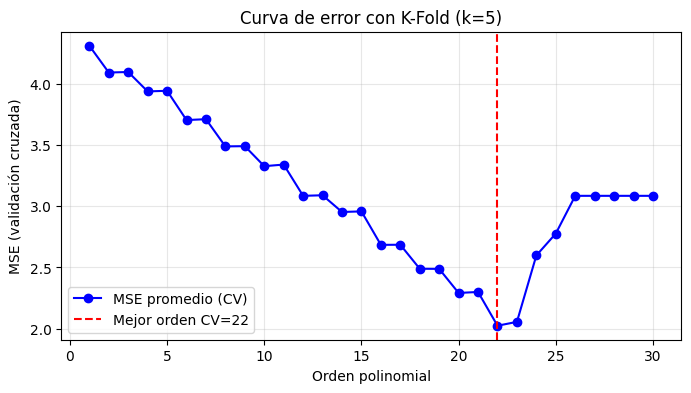

In [7]:
# Bloque 6: validación cruzada con K-Fold
from sklearn.model_selection import KFold, cross_val_score

max_order_cv = 30        # probamos órdenes más pequeños para comparación visual
k = 5                    # número de folds
results_cv = []

for Q in range(1, max_order_cv + 1):
    # generar características polinomiales
    poly = PolynomialFeatures(degree=Q, include_bias=True)
    Phi = poly.fit_transform(X)   # usamos todos los datos (no split aquí)

    # modelo Ridge
    model = Ridge(alpha=alphaR, random_state=RANDOM_STATE)

    # validación cruzada
    cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, Phi, y, cv=cv, scoring='neg_mean_squared_error')

    mse_cv = -scores.mean()
    results_cv.append((Q, mse_cv))

    if Q <= 5 or Q % 5 == 0:
        print(f"[CV] Orden {Q:02d} -> MSE promedio (k={k}) = {mse_cv:.6e}")

# elegir mejor orden según CV
best_cv_order, best_cv_mse = min(results_cv, key=lambda x: x[1])
print(f"Mejor orden por CV: {best_cv_order}, con MSE promedio = {best_cv_mse:.6e}")

# Visualización de curva de error por validación cruzada
orders, mse_vals = zip(*results_cv)
plt.figure(figsize=(8,4))
plt.plot(orders, mse_vals, 'bo-', label='MSE promedio (CV)')
plt.axvline(best_cv_order, color='r', linestyle='--', label=f'Mejor orden CV={best_cv_order}')
plt.xlabel("Orden polinomial")
plt.ylabel("MSE (validación cruzada)")
plt.title(f"Curva de error con K-Fold (k={k})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Predecir con el mejor modelo y graficar ajuste completo y un zoom

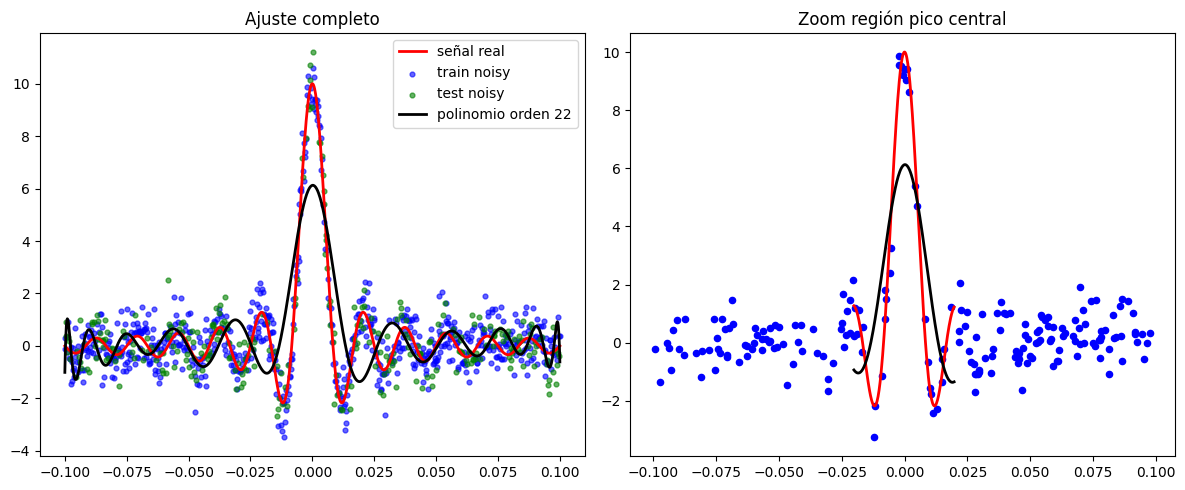

In [8]:
# Bloque 7: predecir con el mejor modelo y graficar ajuste completo y un zoom
best_model = best['model']
best_poly  = best['poly']
y_pred_best = best_model.predict(best_poly.transform(X))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(X, y_clean, 'r-', label='señal real', linewidth=2)
plt.scatter(X_train, y_train, c='blue', s=12, alpha=0.6, label='train noisy')
plt.scatter(X_test, y_test, c='green', s=12, alpha=0.6, label='test noisy')
plt.plot(X, y_pred_best, 'k-', linewidth=2, label=f'polinomio orden {best["order"]}')
plt.legend(); plt.title('Ajuste completo')

plt.subplot(1,2,2)
center_idx = np.argmax(y_clean)
rng = 100
start = max(0, center_idx - rng)
end   = min(len(X), center_idx + rng)
plt.plot(X[start:end], y_clean[start:end], 'r-', linewidth=2)
plt.scatter(X_train[start:end], y_train[start:end], c='blue', s=20)
plt.scatter(X_test[start:end], y_test[start:end], c='green', s=20)
plt.plot(X[start:end], y_pred_best[start:end], 'k-', linewidth=2)
plt.title('Zoom región pico central')
plt.tight_layout()
plt.show()


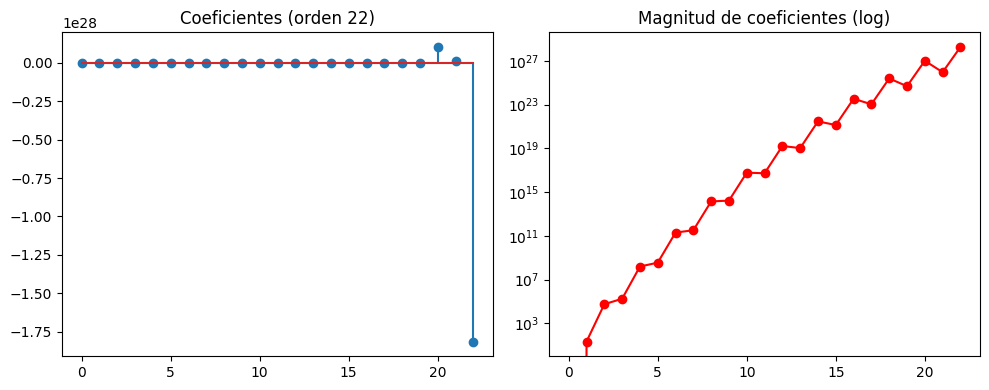

In [9]:
# Bloque 8: ver coeficientes del mejor modelo
coefs = best_model.coef_
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.stem(range(len(coefs)), coefs)
plt.title(f'Coeficientes (orden {best["order"]})')
plt.subplot(1,2,2)
plt.semilogy(range(len(coefs)), np.abs(coefs), 'ro-')
plt.title('Magnitud de coeficientes (log)')
plt.tight_layout()
plt.show()

# _______________Parte_2_______________

### Librerías y parámetros

In [1]:
# Bloque 0: librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Cargar y explorar el dataset

Shape X: (20640, 8) Shape y: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


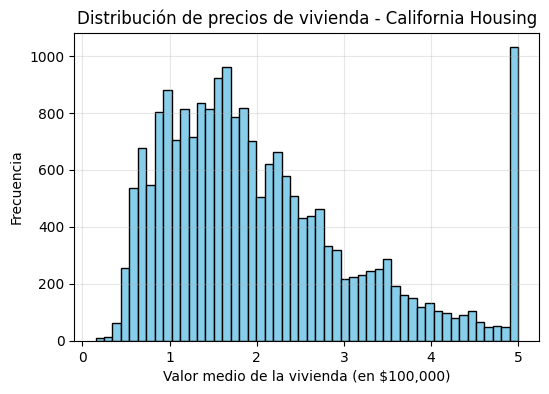

In [2]:
# Bloque 1: cargar dataset California Housing
data = fetch_california_housing()
X, y = data.data, data.target

print("Shape X:", X.shape, "Shape y:", y.shape)
print("Features:", data.feature_names)

# convertir a DataFrame para visualizar
df = pd.DataFrame(X, columns=data.feature_names)
df["target"] = y
print(df.head())

# Visualización rápida: histograma de la variable objetivo
plt.figure(figsize=(6,4))
plt.hist(y, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Valor medio de la vivienda (en $100,000)")
plt.ylabel("Frecuencia")
plt.title("Distribución de precios de vivienda - California Housing")
plt.grid(alpha=0.3)
plt.show()


### División Train/Test

In [3]:
# Bloque 2: división 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)

print("Entrenamiento:", X_train.shape, "Prueba:", X_test.shape)


Entrenamiento: (14448, 8) Prueba: (6192, 8)


### Función para entrenar Ridge polinomial

In [4]:
# Bloque 3: función para entrenar y evaluar
def fit_poly_ridge_and_eval(X_train, y_train, X_test, y_test, degree, alpha=1e-2):
    """
    Aplica transformación polinomial + Ridge y devuelve errores MSE.
    """
    pipeline = Pipeline([
        ("scaler", StandardScaler()),                     # escalar datos
        ("poly", PolynomialFeatures(degree=degree)),      # expansión polinomial
        ("ridge", Ridge(alpha=alpha, random_state=RANDOM_STATE))
    ])
    pipeline.fit(X_train, y_train)

    # predicciones
    pred_train = pipeline.predict(X_train)
    pred_test  = pipeline.predict(X_test)

    # errores
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test  = mean_squared_error(y_test, pred_test)

    return {"model": pipeline, "mse_train": mse_train, "mse_test": mse_test}


### Evaluar diferentes órdenes de polinomio

Orden 1: Train MSE=0.5234, Test MSE=0.5306
Orden 2: Train MSE=0.4236, Test MSE=0.4550
Orden 3: Train MSE=0.3435, Test MSE=19.2883


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.24672e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Orden 4: Train MSE=0.2824, Test MSE=10661.0146
Orden 5: Train MSE=0.2351, Test MSE=138940.3396


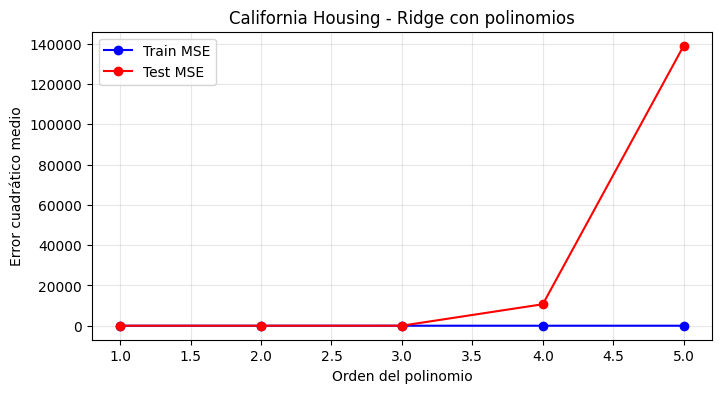

In [5]:
# Bloque 4: probar diferentes órdenes
# Dice cómo evoluciona el error con el grado del polinomio

max_order = 5  # cuidado: grados altos generan muchas variables
alphaR = 1e-2
results = []

for Q in range(1, max_order + 1):
    res = fit_poly_ridge_and_eval(X_train, y_train, X_test, y_test, degree=Q, alpha=alphaR)
    results.append((Q, res["mse_train"], res["mse_test"]))
    print(f"Orden {Q}: Train MSE={res['mse_train']:.4f}, Test MSE={res['mse_test']:.4f}")

# Graficar curva de errores
orders, mse_train, mse_test = zip(*results)
plt.figure(figsize=(8,4))
plt.plot(orders, mse_train, "bo-", label="Train MSE")
plt.plot(orders, mse_test, "ro-", label="Test MSE")
plt.xlabel("Orden del polinomio")
plt.ylabel("Error cuadrático medio")
plt.title("California Housing - Ridge con polinomios")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




### Validación cruzada con K-Fold

[CV] Orden 1: MSE promedio=0.5306
[CV] Orden 2: MSE promedio=100.8244
[CV] Orden 3: MSE promedio=1059053.8500


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.37058e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.62804e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.98623e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.61131e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.26022e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[CV] Orden 4: MSE promedio=723626963724.7014
[CV] Orden 5: MSE promedio=40482264520168360.0000


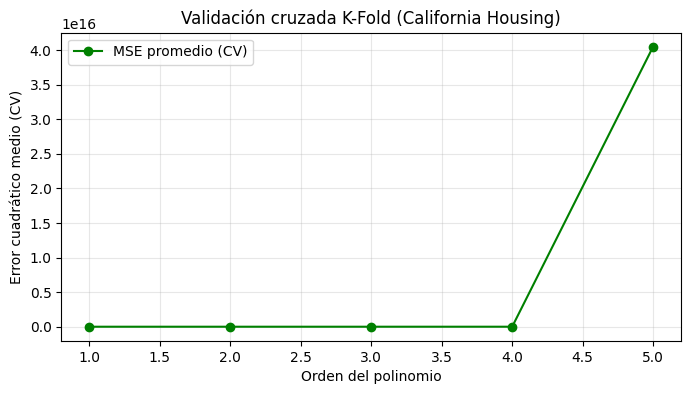

In [6]:
# Bloque 5: validación cruzada K-Fold
k = 5
results_cv = []
for Q in range(1, max_order + 1):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=Q)),
        ("ridge", Ridge(alpha=alphaR, random_state=RANDOM_STATE))
    ])
    cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_squared_error")
    mse_cv = -scores.mean()
    results_cv.append((Q, mse_cv))
    print(f"[CV] Orden {Q}: MSE promedio={mse_cv:.4f}")

# Graficar curva CV
orders, mse_cv = zip(*results_cv)
plt.figure(figsize=(8,4))
plt.plot(orders, mse_cv, "go-", label="MSE promedio (CV)")
plt.xlabel("Orden del polinomio")
plt.ylabel("Error cuadrático medio (CV)")
plt.title("Validación cruzada K-Fold (California Housing)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [10]:
# Encontrar el mejor grado según Test MSE
best_degree_test = np.argmin(mse_test) + 1
best_test_mse = mse_test[best_degree_test-1]

# Encontrar el mejor grado según Validación Cruzada (CV MSE)
best_degree_cv = np.argmin(mse_cv) + 1
best_cv_mse = mse_cv[best_degree_cv-1]

print("="*50)
print("MEJOR MODELO POLINOMIAL")
print("="*50)
print(f"-> Según datos de prueba: orden {best_degree_test} con MSE test = {best_test_mse:.6f}")
print(f"-> Según validación cruzada: orden {best_degree_cv} con MSE CV = {best_cv_mse:.6f}")


#La diferencia ocurre porque la validación cruzada es más estricta: evalúa el modelo en varios folds y da una medida más robusta de qué tan bien generaliza.
#Orden 2 funciona mejor en este conjunto específico de prueba.
#Orden 1 parece más estable en promedio (según CV).

MEJOR MODELO POLINOMIAL
-> Según datos de prueba: orden 2 con MSE test = 0.454959
-> Según validación cruzada: orden 1 con MSE CV = 0.530572


#### En el caso de la señal sinc, conocemos la función matemática "real" y podemos comparar el ajuste directamente contra esa señal limpia, identificando el polinomio que mejor la aproxima. En el dataset California Housing no existe una señal limpia conocida, solo observaciones reales; por eso el mejor polinomio se elige en función del error de predicción (MSE) en test o en validación cruzada, buscando el orden que logra el mejor compromiso entre underfitting y overfitting.